## Imports 📦

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

## Load Data 💿

In [3]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [4]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [5]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [8]:
pip install laserembeddings

Note: you may need to restart the kernel to use updated packages.


In [9]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [10]:
en_text_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [11]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [12]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [13]:
es_emoji_array.shape

(280, 300)

## Concatenate the text embeddings and emoji embeddings 

In [14]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [15]:
en_embeddings.shape

(280, 1324)

## Variable names 📇
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)

## Hierarchical Clustering 🪜

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_samples

def apply_hierarchical_clustering(lang_embeddings, lang_df):
    # method = 'single', 'complete', 'average' don't cluster well
    linkage_matrix = linkage(lang_embeddings, method='ward')
    
    # Plotting dendrogram
    plt.figure(figsize=(24, 16))
    dendrogram(linkage_matrix, labels=lang_df['text'].tolist(), orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Comments')
    plt.ylabel('Distance')
    plt.show()

    # can try different thresholds and criterion
    cluster_labels = fcluster(linkage_matrix, t=3, criterion='distance')

    silhouette_scores = silhouette_samples(lang_embeddings, cluster_labels)

    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "cluster": cluster_labels,
        "silhouette_score": silhouette_scores
    })

    cluster_mean_silhouette = df_clusters.groupby('cluster')['silhouette_score'].mean().reset_index()
    df_clusters = df_clusters.merge(cluster_mean_silhouette, on='cluster', suffixes=('', '_mean'))
    df_clusters = df_clusters.sort_values(by='silhouette_score_mean', ascending=False).drop('silhouette_score_mean', axis=1)

    return df_clusters, cluster_mean_silhouette

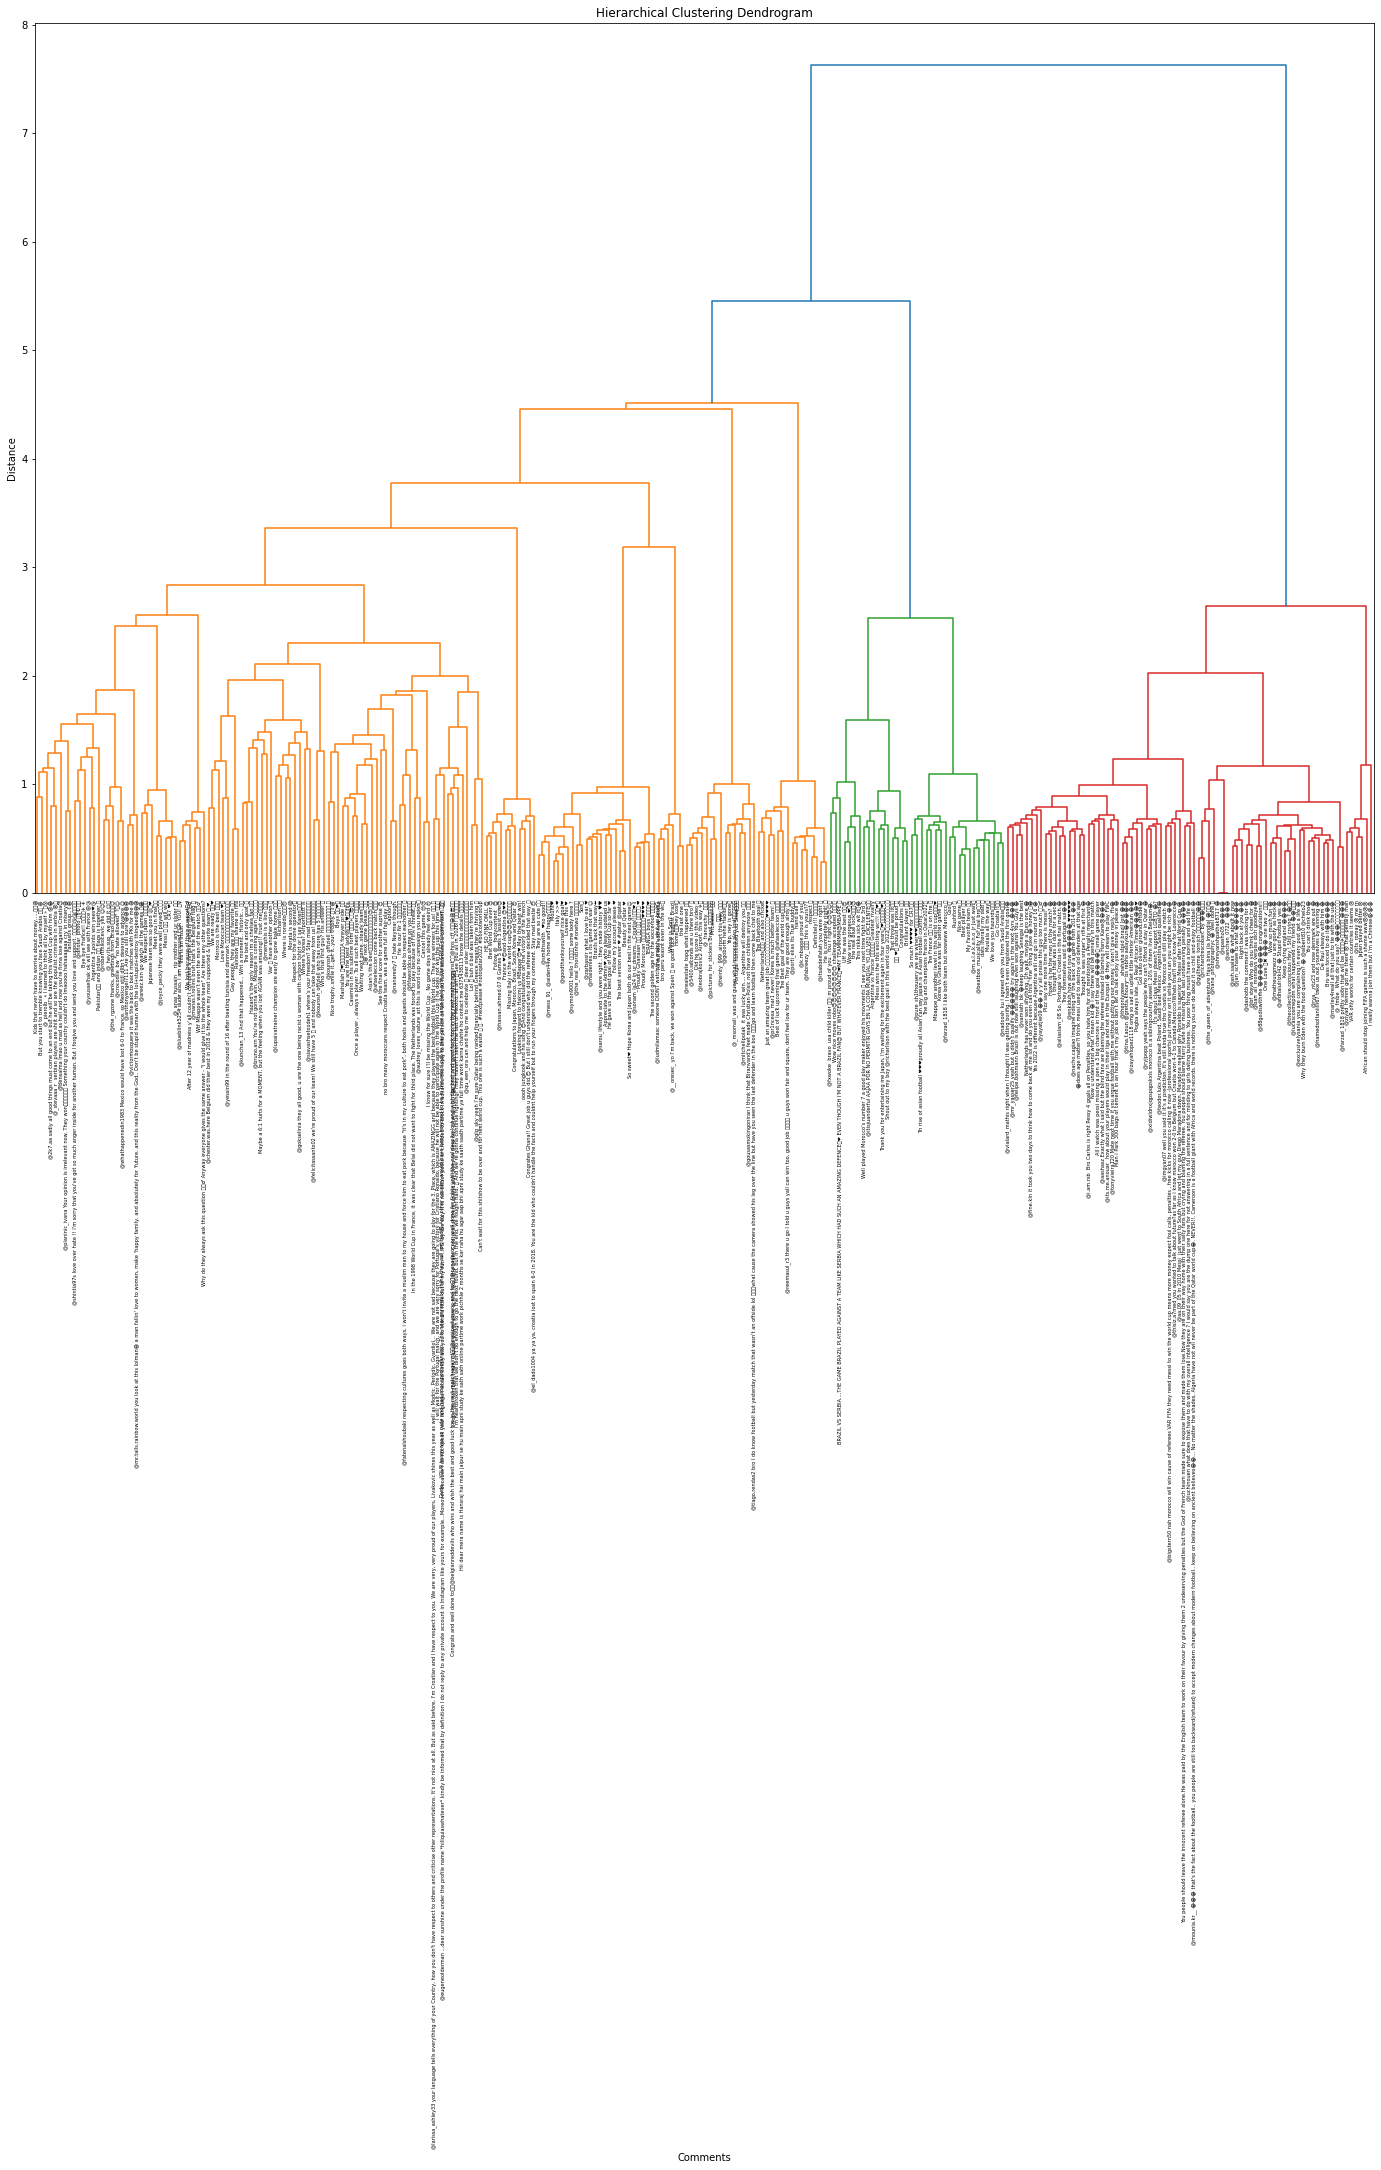

In [51]:
# Perform hierarchical clustering
en_linkage_matrix, en_mean_silhouette = apply_hierarchical_clustering(en_embeddings, en_df)

In [19]:
en_linkage_matrix

,text,cluster,silhouette_score
279,They kost💀,5,0.496161
278,@ludmilamasc someone DIDNT watch the match. sh...,5,0.512258
277,bro peru wasnt even in the wc💀,5,0.509701
276,"@__oresec_ yo I’m back, we won against Spain 💀...",5,0.468551
275,All out lets add new people\n\nWhere is Son?\n...,5,0.501797
...,...,...,...
162,@lupaivatrainer champion are early to gone bak...,8,-0.237944
163,Caption 💯,8,-0.123070
164,Mashallah 🙌❤️🇲🇦🇲🇦🇲🇦A forever pride 👏💪,8,-0.157364
165,Respect for the drone operator🛐,8,-0.176191


In [20]:
en_mean_silhouette

,cluster,silhouette_score
0,1,0.346112
1,2,0.224781
2,3,0.476288
3,4,0.417821
4,5,0.498986
5,6,0.485666
6,7,0.422899
7,8,-0.124502


In [21]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 5]['text'].tolist()

['They kost💀',
 '@ludmilamasc someone DIDNT watch the match. shut up bruh💀.',
 'bro peru wasnt even in the wc💀',
 '@__oresec_ yo I’m back, we won against Spain 💀 so good luck against Brazil',
 'All out lets add new people\n\nWhere is Son?\nHome💀💀',
 'the last one 💀']

In [22]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 6]['text'].tolist()

['Italy >>❤️',
 'Proudly Ghanaian 🇬🇭 🇬🇭 🇬🇭 🇬🇭 🇬🇭 ❤️',
 'Follow m’y account please ❤️',
 '@maidenles.s its game not war ☺️',
 'Mount❤️',
 '@smithswith_ ❤️so good!!',
 'Beauty of Qatar ❤️',
 '@the_real_thorstinho #onetwo 🤭🤭🤭🤭🤭',
 'The best version ever ❤️ #qatar @qatar',
 '@goodthanksyourself nice goal❤️',
 '@zarbassir what I love to ear ❤️',
 'He gave us the best goal of the World Cup so far ❤️',
 'The second golden age for the socceroos 🇦🇺🟡🟢',
 'Loveee this ❤️',
 'Son🥺',
 'They are so cute \U0001f979\U0001f979',
 '@sarou_lifestyle and you were right , they made history ♥️♥️',
 'Appreciate to the Admin❤️ who always updated us',
 'Proudly Moroccan 🇲🇦🇲🇦🇲🇦🇲🇦❤️❤️❤️❤️',
 '@mess_91_ @aiden44w home and happy🥳🥳🤌🏻',
 '@symon9001 hello ? 🤟🏽🇦🇷 some body here ?',
 'Brazils back that way⬅️',
 'TERANGA boys 🇸🇳🇸🇳❤️',
 '@sonam_la24 in ur dreams... Croatia!!!🇭🇷❤️✌️',
 'So sweet❤️ Hope Korea and Japan both do our best in the next game☺️']

In [23]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 3]['text'].tolist()

['@pr1ncesa_mar1 never! Korea is much better team! 👏',
 'Just an amazing team great job 👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻❤️❤️❤️❤️',
 '@k.mbappe proud of you👏',
 'Definitely!!! 👏👏👏👏👏',
 'Best of luck upcoming final game @afaseleccion 👏👏👏🏆',
 '@porti_elias Its True buddy👏👏',
 '@reemasul_r3 there u go I told u guys yall can win too, good job 👏🏻👏🏻 u guys won fair and square, dont feel low for ur team. They are good enough alrdy 👏🏻',
 '@fabreezy_ 👏👏👏 this is yours???',
 'The Best goal of the world cup👏👏👏⚽️',
 'He is completely right! 👏',
 'respect 👏',
 'Netherlands👏👏👏 and also cricket',
 'hand ball 👏',
 'The Bluetooth goal 👏',
 '@itsabdelfatah you were right 👏']

In [24]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 7]['text'].tolist()

['Best World Cup ever 😍',
 "Congrates Ghana!! Great job u guys did.😍 But I still don't understand why did the referee decided that way. 🥲",
 'Missing Italy in the world cup😍😍😍🇮🇹🇮🇹🇮🇹',
 'Congratulations to Japan, Morocco, Brazil, South Korea and Qatar 😍',
 'HE SO FINE OMLL 😍',
 'Follow @__footycontent_ 😍',
 'France ❤️😍and Argentina 😍❤️❤️',
 "Looking forward to Hakimi vs MBappe'😍❤️ May the best win!",
 "@el_dado1004 ya ya ya, croatia lost to spain 6-0 in 2018. You are the kid who couldn't handle the facts and couldnt help yourself but to run your fingers through my comment. Stay mad bestie 😍",
 '@hassan.ahmed.07 6 Games 5 goals 3 assist now😍',
 'oooh jungkook and his song 😍And congratulations on the victory of the French']

In [25]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 4]['text'].tolist()

['Yep, ney is gone🤣',
 'Did he score in this video 🤣',
 '@twinty_999  airport this way 🤣👍🏻',
 '@_francechy_ 🤣🤣🤣',
 '@5400.seconds are u there bro? 🤣',
 "@gousasmokingoniran I think that Biranvand's feet made Christian Polsic not have children anymore 🤣🤣🤣",
 '@realestate_topg what happened 🤣🤣',
 '@mitchellpolak  it was lucky win.... Argentine will destroy you 🤣🤣',
 'Priceless!! 🇨🇲\n🤣🤣🤣',
 "@tiago.rendas2 bro I do know football but yesterday match that wasn't an offside lol 🤣🤣🤣what cause the camera showed his leg over the line but have you seen the last defender in the box 🤣🤣🤣go and learn football then come back chat to me",
 'Portugal humiliated you Shaq🤣🤣🤣\n￼',
 '@pictures_for_stickers Brazil 🇧🇷🛫🏠🤣🤣🤣🤣',
 '@_msomali_wao and guess what morocco also lost🤣🤣🤣🤣🤣🤣',
 '@goborm hehe Habibi🤣🤣',
 '@leobrajkovic2 Airport, this way ✈️🤣']

## Spanish

In [26]:
pip install googletrans==4.0.0-rc1

  Using cached httpx-0.13.3-py3-none-any.whl (55 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached httpcore-0.9.1-py3-none-any.whl (42 kB)
  Using cached h11-0.9.0-py2.py3-none-any.whl (53 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.2
    Uninstalling httpcore-1.0.2:
      Successfully uninstalled httpcore-1.0.2
  Attempting uninstall: httpx
    Found existing installation: httpx 0.25.1
    Uninstalling httpx-0.25.1:
      Successfully uninstalled httpx-0.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.

In [27]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function to translate a text
def translate_text(text, target_language='en'):
    try:
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        return str(e)

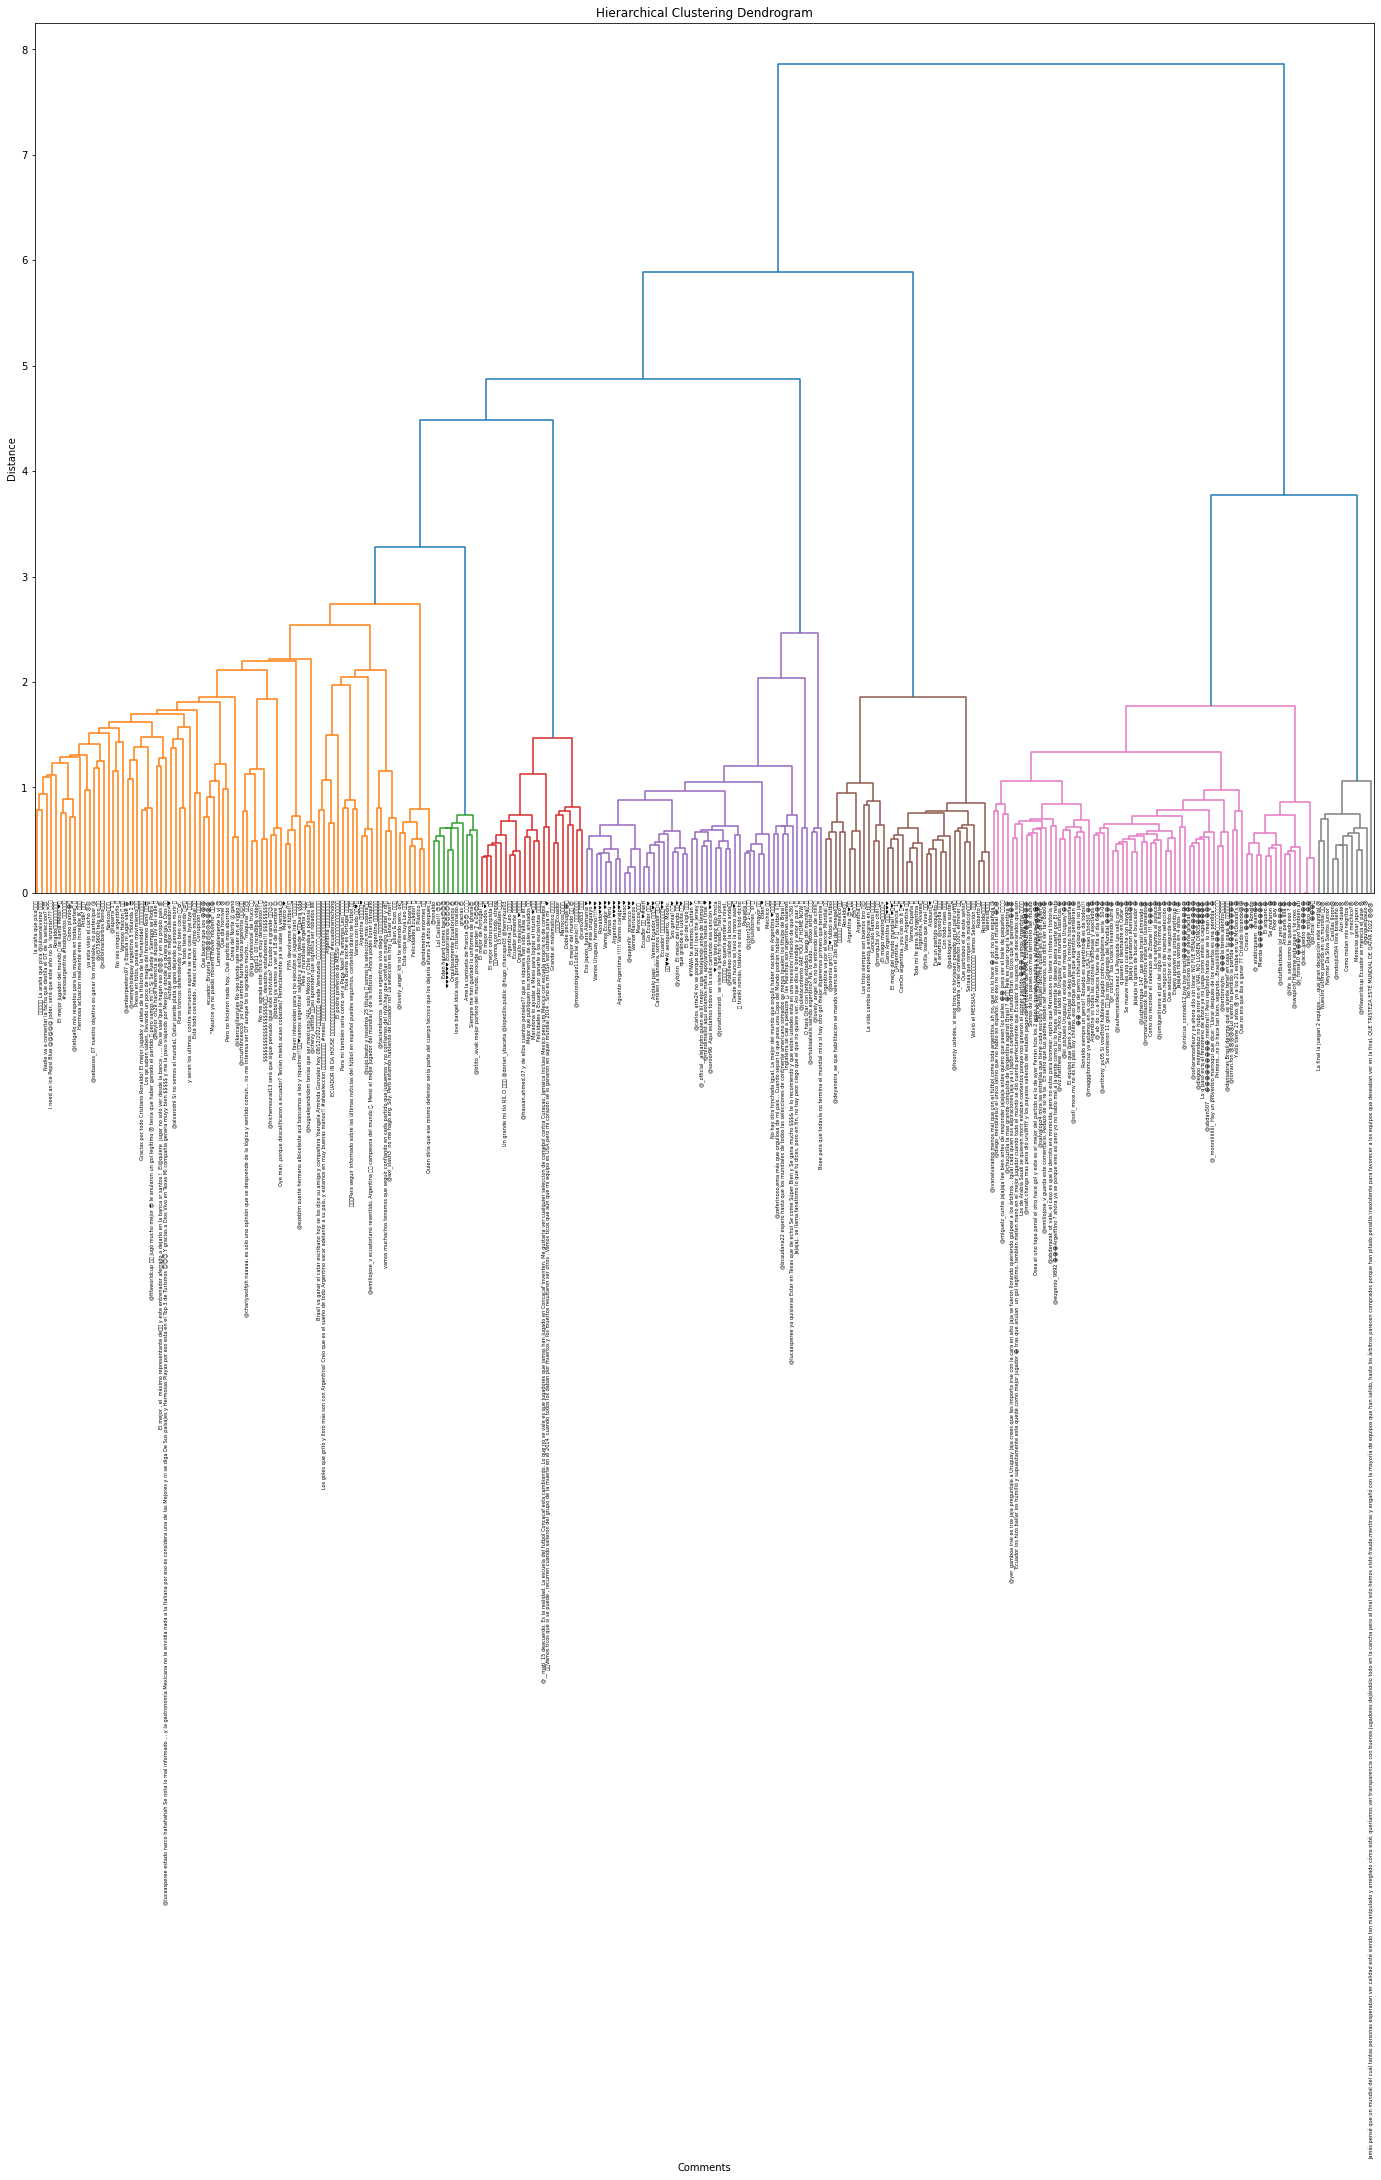

In [28]:
es_linkage_matrix, es_mean_silhouette = apply_hierarchical_clustering(es_embeddings, es_df)

In [29]:
es_linkage_matrix['translated_text'] = es_linkage_matrix['text'].apply(translate_text, target_language='en')
es_linkage_matrix

,text,cluster,silhouette_score,translated_text
0,Orgullosamente Ecuatorianos 😍,6,0.502996,Proudly Ecuadorians 😍
2,"@btito_.avak mejor portero del mundo, procede ...",6,0.443004,"@Btito_.Avak Best goalkeeper in the world, pro..."
3,Eden hazard comes back😍😍😍,6,0.480451,Eden hazard comes back😍😍😍
4,love banget idola saya portugal - cristiano ro...,6,0.451412,I really love my idol Portugal - Cristiano Ron...
5,Siempre me han gustado lo uniformes de ghana😍,6,0.472199,I have always liked Ghana's uniforms😍
...,...,...,...,...
45,El Plástico 🙌,7,-0.021197,The plastic 🙌
44,@ezebtm suerte hermano albiceleste acá bancamo...,7,-0.047228,@Ezebtm Lucky Brother Albiceleste here we bank...
43,"Oye man ,porque descalificaron a ecuador? Tení...",7,-0.100248,"Hey Man, why did they disqualify Ecuador?They ..."
42,la araña que pica🤘🏻🕷️,7,-0.154299,The spider that Pica🤘🏻🕷️


In [30]:
es_mean_silhouette

,cluster,silhouette_score
0,1,0.428671
1,2,0.379912
2,3,0.388194
3,4,0.413665
4,5,0.394112
5,6,0.468130
6,7,-0.103273


In [31]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 6]['translated_text'].tolist()

['Proudly Ecuadorians 😍',
 '@Btito_.Avak Best goalkeeper in the world, proceeds to lose 7 to 0😍😍😍',
 'Eden hazard comes back😍😍😍',
 'I really love my idol Portugal - Cristiano Ronaldo.😍',
 "I have always liked Ghana's uniforms😍",
 'Love the France shirt 😍😍😍 🇺🇾🇨🇵',
 'Lol Casillas!!! 😍😍',
 'gracias 😍',
 '😍ronaldo',
 '❤️❤️❤️ located Ecuadorians 😍😍😍😍😍']

In [32]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 1]['translated_text'].tolist()

['@guiguelpaulo 😢',
 'How are my blacks shit 😢',
 '@fifaworldcup Ecuador deserved the pass 😢',
 'It still hurts',
 'and mechico? 😢',
 'I never thought that a World Cup from which so many people expected to see quality is being so manipulated and fixed how it is, we wantedOut, even the referees seem bought because they have been a non -existent penalty to favor the teams they wanted to see in the final, how sad is the world of Qatar 2022 😢😢😢.',
 'You deserved to win Japon 😢',
 'Neymar da Silva Santos Junior 😢',
 '@mdsojid364 cries Brazilian 😢',
 'Casillas Lloron😢',
 'Our last game in a World Cup 🇨🇴😢',
 'The final is played by 2 teams ...... What great disappointment this World Cup 😢']

In [33]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 4]['translated_text'].tolist()

['@_Ompoficial__Alejandro who is the best, continue to celebrate ahead of time 🤫',
 'the eldest 🤩🤩',
 'Ecuador 🇪🇨 ❤️#win',
 '@Luisitorres_ Yes 🥵',
 'That Japan, outside Germany ❤️',
 '@fabilleao Shock your mouth go',
 '@lucaasperee you would already want to be in Texas that Echol eats super good and you earn a lot $$$ & I recommend it and that you are in a recession/ inflation that %80 🥵',
 'Boee so that the World Cup is still not over if there is another better goal we hope first than end 🤙',
 'There is no other fans the same.The best in the world that proud to have been born in Argentina ❤️🇦🇷🇦🇷',
 'From there the hand was washed AAA❤️\u200d🩹',
 "Argentina feed !!!!!Let's fuck bla ining",
 'Morocco❤️',
 'England falls to pieces 🥱, the Malvinas are Argentinas Salames',
 'Ronaldo❤️❤️❤️',
 '@bcaudana22 I wait until the World Cups of all the American continent selections somados less equal to the titles of Brazil \U0001fae1',
 '@jonathanardi_ The friad chest is coming 🥶 little is missing'

In [34]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 5]['translated_text'].tolist()

['@caro2653 👏👏👏',
 'Moroccs👏👏👐👐',
 'Argentina 🇦🇷 Leo 👏👏👏👏',
 '@hassan.ahmed.07 And how many penalties?that they have not even been fouls to El.👏👏',
 "@__ mati_15 agreement.It's reality.The Concacaf Soccer School is changing.What is not worth is that players who have never played in Concacaf invent.I would like to see any comebol selection against Curacao, Jamaica even Mexico but um mexico with School propria no de comebol 👏",
 '@Maxirodriguez11Oficial genius !!!👏👏👏👏💙🤍💙',
 'Double breast 😂👏',
 'The best midfielder 👏🏻',
 'A great my uncle Ril or 👏👏👏 @dorian_ybaceta @lopezillo.public @hugo_charcape03 @hanrykux03',
 'Great the mathematician',
 'The best in Portugal 👏👏',
 'Better publish the moments of canceled goals 👏👏',
 'Mexican pride ❤️👏🏻🇲🇽',
 'Maradona help Messi to achieve triumph ❤️👏👏👏',
 'Ecuador present 🇪🇨👏👏',
 "We are thicerly that if one can, they turn to when they left the death group in 2014 when they all gave them for dead and the dead turned out to be others.Let's go even if 

In [35]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 3]['translated_text'].tolist()

['All my faith for Argentina 🔥',
 '@Borenia Grs !!!🔥🙌❤️ Soccer is football',
 '@marqu3si yo bro chill 👏🔥',
 'Argentina 🔥💚',
 "What's up the one of this lord🔥",
 '@hilla_loaiza what level 🔥🔥🔥',
 'Aidoun 🔥❤️',
 'Ronaldo🔥🔥🔥🔥',
 "Messias returned 🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷 Let's go selection 🔥🔥🔥",
 '@deyaneira_ae to enable Valencia in the 2nd goal of Senegal🙌🔥🔥',
 '@pablogavi good luck🔥',
 'Valencia🔥🔥🔥',
 '😍ñ🔥🔥🔥',
 'It will be to break the curse🔥🔥🔥',
 '@hoonjy you, if those shots did not get stuck in the Uffff stick🔥',
 '@sandra_cariel camereron 100% 🔥🔥',
 'Life changes when it begins to focus on you🎶🔥',
 "Let's go Spain 🔥",
 'We love you @yosoy8a 🇲🇽🔥',
 'The master magician🔥🔥🤍👏🏻⚡',
 'Ronaldo🙌🔥',
 'With every teacher 🔥🇨🇷',
 'The best in the world!❤️\u200d🔥❤️\u200d🔥',
 'The trios are always good bro 🔥😉',
 'Goncalo Ramos 🔥🔥👏👏',
 'Argentina goes for the third World Cup 🙌🔥',
 'CommOn argentina..you can do it 🔥❤️🔥',
 'Roberto 🔥🔥',
 '🔥Argentina.3 🔥 France 1🔥',
 'Argentina, Alvares🔥',
 'Argentina 😍❤️🔥🔥',
 '🔥🔥🔥